# Multiplane imaging workflow
Notebook set up as described by babcock et al. [https://storm-analysis.readthedocs.io/en/stable/analysis.html](https://storm-analysis.readthedocs.io/en/stable/analysis.html). 
* starting point is cropped planes from raw camera frames set up in separate folders
* calibration file is created from accent calibration script by ries lab and converted into the appropriate format for this processing




In [1]:
# general imports 
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import pickle
from tkinter import filedialog
from tkinter import *
import json

In [2]:
def load_multiplane_calibration(filename):
    if not os.path.exists(filename):
        # ask for user input for calibraiton
        root = Tk()
        root.withdraw()
        filepath = filedialog.askopenfile(title='Select calibration data file', filetypes =[('Calibration file', '*.json')])
        fopen = filepath.name
    else:
        fopen = os.path.join(filename)
    f = open(fopen)
    cal = json.load(f, object_hook=jsonKeys2int) 
    return cal


def jsonKeys2int(x):
    if isinstance(x, dict):
        return {(int(k) if k.isnumeric() else k):v for k,v in x.items()}
    return x

Load and display parameter and calibration files 

In [3]:
root = r'F:\moritz\babcock_test\kg'
os.chdir(root)
print(os.getcwd())

filepath_mcal = os.path.join(root, 'cal.json')
mcal = load_multiplane_calibration(filepath_mcal)

#filepath_scmos_cal1 = os.path.join(root, 'cal.json')
#filepath_scmos_cal2 = 

analysis_params = 'daofit.xml'
zcal_fit_params = 'zcal.xml'
#filepath_analysis_params = os.path.join(root, analysis_params)

# processing parameters
ref_plane = 0 # python indexing
exp_time = 10
pixel_size = 108
camera_gain = 5
camera_offset = 100
iterations = 1000
model = '2dfixed'
dz = 20
focus_plane = int(mcal['psf_slices']/2)

F:\moritz\babcock_test\kg


In [4]:
import storm_analysis.sa_library.parameters as parameters
def createParametersFile(max_frame, start_frame, filename, roi_size=15):
    """
    Create a 3D-DAOSTORM parameters file.
    """
    params = parameters.ParametersDAO()

    params.setAttr("max_frame", "int", max_frame)    
    params.setAttr("start_frame", "int", start_frame)
    
    params.setAttr("background_sigma", "float", 8.0)
    params.setAttr("camera_gain", "float", camera_gain)
    params.setAttr("camera_offset", "float", camera_offset)
    params.setAttr("find_max_radius", "int", 5)
    params.setAttr("foreground_sigma", "float", 3.0)
    params.setAttr("iterations", "int", iterations)
    params.setAttr("model", "string", model)
    params.setAttr("pixel_size", "float", pixel_size)
    params.setAttr("roi_size", "int", roi_size)
    params.setAttr("sigma", "float", 3)
    params.setAttr("threshold", "float", 11.0)

    params.setAttr("no_fitting", "int", 0)

    # Z fitting.
    params.setAttr("do_zfit", "int", 0)

    params.setAttr("cutoff", "float", 0.0)    
    params.setAttr("max_z", "float", 0.5)
    params.setAttr("min_z", "float", -0.5)
    params.setAttr("z_value", "float", 0.0)
    params.setAttr("z_step", "float", 0.001)

    params.setAttr("wx_wo", "float", 300.0)
    params.setAttr("wx_c", "float", 150.0)
    params.setAttr("wx_d", "float", 400.0)
    params.setAttr("wxA", "float", 0.0)
    params.setAttr("wxB", "float", 0.0)
    params.setAttr("wxC", "float", 0.0)
    params.setAttr("wxD", "float", 0.0)

    params.setAttr("wy_wo", "float", 300.0)
    params.setAttr("wy_c", "float", -150.0)
    params.setAttr("wy_d", "float", 400.0)
    params.setAttr("wyA", "float", 0.0)
    params.setAttr("wyB", "float", 0.0)
    params.setAttr("wyC", "float", 0.0)
    params.setAttr("wyD", "float", 0.0)

    # Do tracking.
    params.setAttr("descriptor", "string", "1")
    params.setAttr("radius", "float", "0.5")

    # Do drift-correction.
    params.setAttr("d_scale", "int", 2)
    params.setAttr("drift_correction", "int", 0)
    params.setAttr("frame_step", "int", 500)
    params.setAttr("z_correction", "int", 0)
    
    params.toXMLFile(filename)


createParametersFile(max_frame=focus_plane+1, start_frame=focus_plane, filename=analysis_params, roi_size=17)

createParametersFile(max_frame=-1, start_frame=-1, filename=zcal_fit_params, roi_size=17)

### daostorm fitting of bead stack focal planes for marker ID in .hd5f

In [ ]:
from storm_analysis.daostorm_3d.mufit_analysis import analyze
#from storm_analysis.sa_utilities. hdf5_to_image import render2DImage
import storm_analysis.jupyter_examples.overlay_image as overlay_image
#pattern = r'fp_(\d+)\.tiff'
pattern = r'beads_zcal_ch(\d+)\.tiff'

focal_planes_list = [f for f in os.listdir(root) if re.match(pattern, f)]
for f in focal_planes_list:
    id_group = re.match(pattern, f)
    outname = f'locs_plane_{int(id_group.group(1))}.hdf5'

    # development
    if os.path.isfile(os.path.join(root, outname)):
        os.remove(os.path.join(root, outname))

    analyze(f, outname, analysis_params)
    print(f"Written focal plane locs of z-plane {id_group.group(1)}")
    #plt.imshow(render2DImage(outname))
    #plt.show()
    overlay_image.overlayImage(f, outname, focus_plane)
    


### micrometry mapping of .hd5f locs from focal planes for transforms

In [ ]:
from storm_analysis.micrometry.micrometry import runMicrometry
pattern = r'locs_plane_(\d+)\.hdf5'
maps_list = []
plane_locs_list = [f for f in os.listdir(root) if re.match(pattern, f)]

plane_locs_list

In [ ]:
for idx, f in enumerate(plane_locs_list):
    if idx == ref_plane: 
        continue 
    id_group = re.match(pattern, f)
    outname = f'c{ref_plane+1}_c{int(id_group.group(1))}.map'
    maps_list.append(outname)

    print(f'Using ref: {plane_locs_list[ref_plane]}, target {f} ')
    runMicrometry(f, plane_locs_list[ref_plane], outname)
    print(f"Written mapping: {outname}")

### Merge mappings

In [ ]:
# print mappings
print(f"Maps list: {maps_list}")
for f in maps_list:
    with open(f, "rb") as fp:
        a_map = pickle.load(fp)

    print(f)
    for elt in sorted(a_map):
        print(elt, a_map[elt])
    print()

In [ ]:
from storm_analysis.micrometry.merge_maps import mergeMaps 

merged_map = mergeMaps(maps_list)
#same_maps_list = [f'c1_c1.map']*7
#merged_map = mergeMaps(same_maps_list)

map_name = 'merged_map.map'
with open(map_name, 'wb') as fp:
        pickle.dump(merged_map, fp)

### Measuring the PSF
1) Select good beads from focal plane in a single stack from the ref plane > beads_zcal_ch1.hdf5
2) Select good localizations to use for PSF determination for each channel.
python path/to/psf_localizations.py --bin beads_zcal_ch1.hdf5 --map map.map --aoi_size 12
3) Create averaged z stacks for each channel.

In [5]:
# Run loc fitter on whole stacks
from storm_analysis.daostorm_3d.mufit_analysis import analyze
import storm_analysis.jupyter_examples.multiplane_measure_psf as multiplane_measure_psf

In [ ]:
pattern = r'beads_zcal_ch(\d+)\.tiff'
beadstack_list = [f for f in os.listdir(root) if re.match(pattern, f)]
psf_locs_list = []
for f in beadstack_list:
    print(f"Processing {f}:") 
    id_group = re.match(pattern, f)
    i = int(id_group.group(1))
    whole_stack_locs = f"beads_zcal_ch{i}.hdf5"
    if os.path.exists(whole_stack_locs):
        os.remove(whole_stack_locs)

    analyze(f, whole_stack_locs, zcal_fit_params)

In [6]:
os.chdir(r'E:\GitHub\storm-analysis\storm_analysis\multi_plane')
import kg_psflocalization as psf_localizations
os.chdir(root)

In [7]:
# Select good localizations in one of the analyzed frames (frame 100 in this example)
# We specify a minimum localization separation of 24 pixels (2 x aoi_size).
#import storm_analysis.multi_plane.psf_localizations as psf_localizations

#pattern = r'locs_plane_(\d+)\.hdf5'
pattern = r'beads_zcal_ch(\d+)\.hdf5'
plane_locs_list = [f for f in os.listdir(root) if re.match(pattern, f)]
#ref_locs= f'locs_plane_{ref_plane}.hdf5'
ref_locs= f'beads_zcal_ch{ref_plane+1}.hdf5'
#plane_locs_list = plane_locs_list.remove(ref_locs)

#psf_localizations.psfLocalizations(ref_locs, map_name, frame = int(mcal['psf_slices']/2), aoi_size = 10, min_height = 0.0)
psf_localizations.psfCrossLocalizations(plane_locs_list, frame = int(mcal['psf_slices']/2), aoi_size = 10, min_height = 0.0)

Added 14
14 localizations were kept out of 14
ch0: 113.08 52.21
ch0: 65.14 53.31
ch0: 190.52 70.58
ch0: 120.05 140.40
ch0: 264.18 155.12
ch0: 41.55 161.69
ch0: 113.93 182.16
ch0: 19.46 221.80
ch0: 98.79 222.53
ch0: 76.14 226.88
ch0: 293.14 231.16
ch0: 160.72 263.65
ch0: 76.60 265.55
ch0: 97.77 287.84
Added 16
16 localizations were kept out of 16
ch1: 113.61 53.91
ch1: 65.42 54.83
ch1: 190.97 72.21
ch1: 255.71 116.72
ch1: 253.81 137.69
ch1: 120.38 141.71
ch1: 264.57 156.49
ch1: 42.04 162.93
ch1: 114.32 183.39
ch1: 19.84 222.85
ch1: 99.13 223.40
ch1: 76.55 227.96
ch1: 293.67 232.06
ch1: 161.18 264.60
ch1: 76.98 266.37
ch1: 98.23 288.56
Added 15
15 localizations were kept out of 16
ch2: 114.13 54.34
ch2: 66.32 55.37
ch2: 191.29 72.61
ch2: 255.85 117.24
ch2: 254.01 138.13
ch2: 121.05 142.18
ch2: 264.85 157.11
ch2: 42.57 163.49
ch2: 114.87 183.89
ch2: 20.70 223.30
ch2: 99.91 223.89
ch2: 77.30 228.23
ch2: 293.89 232.63
ch2: 161.69 265.14
ch2: 77.69 266.98
Added 16
16 localizations were kept 

Channel 1 (frame 50)


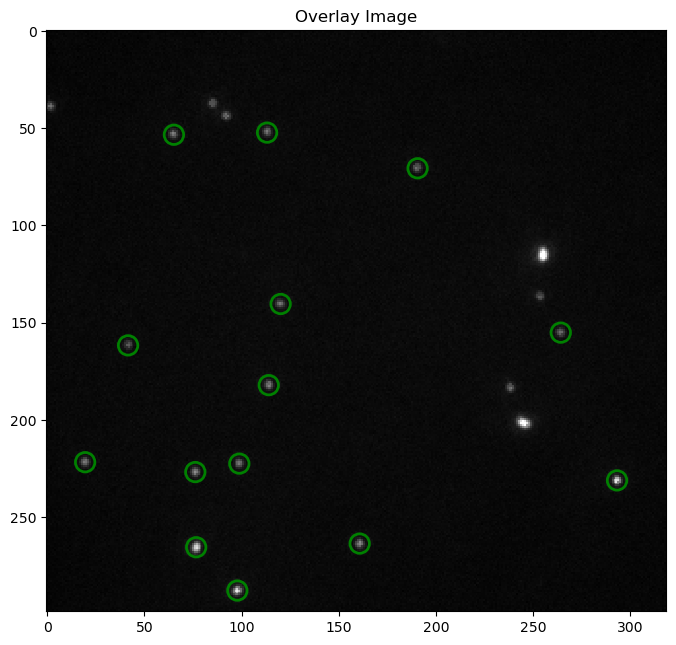

Channel 2 (frame 50)


SAH5PyException: file 'beads_zcal_ch1_c2_psf.hdf5' not found.

In [8]:
pattern = r'beads_zcal_ch(\d+)\.tiff'
beadstack_list = [f for f in os.listdir(root) if re.match(pattern, f)]
psf_locs_list = []
for f in beadstack_list:
    id_group = re.match(pattern, f)
    i = int(id_group.group(1))
    check_locs = f"beads_zcal_ch{i}_c{ref_plane}_psf.hdf5"
    #check_locs = f"beads_zcal_ch{ref_plane}_c{i}_psf.hdf5"
    #check_locs = f"beads_zcal_ch{i}.hdf5"
    psf_locs_list.append(check_locs)
    
    print(f"Channel {i} (frame {int(mcal['psf_slices']/2)})")
    multiplane_measure_psf.overlayImage(f, check_locs, int(mcal['psf_slices']/2))

    #original_locs = f"beads_zcal_ch{i}.hdf5"
    #multiplane_measure_psf.overlayImage(f, original_locs, int(mcal['psf_slices']/2))

In [ ]:
# investigate psf stack visually in imageJ and run xy drift estimation if necessary
from storm_analysis.multi_plane.zstack_xydrift import xyDrift

for f in psf_locs_list:
    [dx, dy] = xyDrift(f)
    print("dx: {0:5f} dy: {1:5f}".format(dx, dy))

In [ ]:
from storm_analysis.multi_plane.psf_zstack import psfZStack  

# needed
pattern = r'beads_zcal_ch(\d+)\.tiff'
beadstack_list = [f for f in os.listdir(root) if re.match(pattern, f)]
#psf_locs_list = []

# new, chec if you can use unpaired locs
pattern_locs = r'beads_zcal_ch(\d+)\.hdf5'
plane_locs_list = [f for f in os.listdir(root) if re.match(pattern_locs, f)]

for f, locs in zip(beadstack_list, psf_locs_list):
#for f, locs in zip(beadstack_list, plane_locs_list):
    print(f"Processing {f}:") 
    id_group = re.match(pattern, f)
    i = int(id_group.group(1))
    psf_stack = f'ch{i+1}_stack'
    psfZStack(f, locs, psf_stack, aoi_size=12)


In [ ]:
from storm_analysis.spliner.offset_to_z import offsetToZ 

z_data = np.arange(start=-0.5*mcal['psf_slices']*mcal['dz_stage']/1000, stop=+0.5*mcal['psf_slices']*mcal['dz_stage']/1000, step= mcal['dz_stage']/1000)
data = np.ones((z_data.size,4))
data[:,3] = z_data

offset_file = 'offset_z_default.txt'

np.savetxt(offset_file, data)
off = offsetToZ(offset_file, dz = 0.0, all_valid = True)

offset_z_file = 'offset_z.txt'
np.savetxt(offset_z_file, off)
z_offsets = np.loadtxt(offset_z_file)
print(z_offsets)

In [ ]:
from storm_analysis.multi_plane.measure_psf import measurePSF
import storm_analysis.jupyter_examples.psf_images as psfImages

pattern = r'ch(\d+)_stack\.npy' 
psf_stack_list = [f for f in os.listdir(root) if re.match(pattern, f)]
psf_names = []
for st, loc in zip(psf_stack_list, psf_locs_list):
    idgroup = re.match(pattern, st)
    psf_name = f'ch{idgroup.group(1)}_psf.psf'
    psf_names.append(psf_name)
    
    measurePSF(st, offset_z_file, psf_name,  
                pixel_size = pixel_size/1000, 
                z_range = 1.0, #0.75 
                z_step = 0.05)

    psfImages.psfImages(psf_name)



In [ ]:
from storm_analysis.multi_plane.normalize_psfs import normalizePSFs

normalizePSFs(psf_names)

In [ ]:
from storm_analysis.multi_plane.check_plane_offsets import checkPlaneOffsets
checkPlaneOffsets(psf_names)


Create the multiplane analysis XML file that we'll need at the plane weighting step.

In [ ]:
import storm_analysis.jupyter_examples.multiplane_psfs_to_splines as multiplane_psfs_to_splines

multiplane_psfs_to_splines.multiplaneXML()